reference:
    https://github.com/fede1024/caffe-experiments/blob/master/memo.txt
    https://github.com/TZstatsADS/Spr2016-Proj3-Grp3/blob/master/output/extractfeature.ipynb
    https://cdn.rawgit.com/TZstatsADS/ADS_Teaching/master/Spring2016/Tutorials/wk7-image_analysis/advanced_image_analysis.html

### 0. Input

* caffepath indicates the root path of the `caffe` package
* inputpath indicates the foler which saves all the images
* outputpath indicates the foler which the features extracted should be saved in

In [23]:
caffepath = '/Users/YaqingXie/caffe'
inputpath = '/Users/YaqingXie/Desktop/3-Applied Data Science/Project3_poodleKFC_train/images'
outputpath = '/Users/YaqingXie/Desktop'

### 1. Setup

* First, set up Python, `numpy`, `panda` and `matplotlib`.

In [38]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [32]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys

if not caffepath.endswith('/'):
    caffepath = caffepath + '/'
if not inputpath.endswith('/'):
    inputpath = inputpath + '/'
if not outputpath.endswith('/'):
    outputpath = outputpath + '/'

caffe_root = caffepath
sys.path.insert(0, caffe_root + 'python')

import caffe

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [22]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [24]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [25]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: <zip object at 0x26b2eed48>


In [26]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

### 3. Feature Extraction

In [27]:
from os import listdir
from os.path import isfile, join
name_list = [f for f in listdir(inputpath) if isfile(join(inputpath, f)) and f.endswith('.jpg')]

* Layer norm1 dimensions: (1, 96, 27, 27) [69984 values]

In [28]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature1 = np.reshape(net.blobs['norm1'].data[0], 69984, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature1 = np.vstack([feature1,np.reshape(net.blobs['norm1'].data[0], 69984, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction finished.


* Layer norm2 dimensions: (1, 256, 13, 13) [43264 values]

In [37]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature2 = np.reshape(net.blobs['norm2'].data[0], 43264, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(input + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature2 = np.vstack([feature2,np.reshape(net.blobs['norm2'].data[0], 43264, order='C')])
    i += 1
print('Feature extraction finished.')

Image reading finished.


* Layer conv3 dimensions: (1, 384, 13, 13) [64896 values]

In [86]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature3 = np.reshape(net.blobs['conv3'].data[0], 64896, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature3 = np.vstack([feature3,np.reshape(net.blobs['conv3'].data[0], 64896, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction reading finished.


* Layer conv4 dimensions: (1, 384, 13, 13) [64896 values]

In [87]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature4 = np.reshape(net.blobs['conv4'].data[0], 64896, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature4 = np.vstack([feature4,np.reshape(net.blobs['conv4'].data[0], 64896, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction reading finished.


* Layer pool5 dimensions: (1, 256, 6, 6) [9216 values]

In [88]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature5 = np.reshape(net.blobs['pool5'].data[0], 9216, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature5 = np.vstack([feature5,np.reshape(net.blobs['pool5'].data[0], 9216, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction reading finished.


* Layer conv5 dimensions: (1, 256, 13, 13) [43264 values]

In [89]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature6 = np.reshape(net.blobs['conv5'].data[0], 43264, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature6 = np.vstack([feature6,np.reshape(net.blobs['conv5'].data[0], 43264, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction reading finished.


* Layer fc6 dimensions: (1, 4096, 1, 1) [4096 values]

In [90]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature7 = np.reshape(net.blobs['fc6'].data[0], 4096, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature7 = np.vstack([feature7,np.reshape(net.blobs['fc6'].data[0], 4096, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction reading finished.


* Layer fc7 dimensions: (1, 4096, 1, 1) [4096 values]

In [91]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature8 = np.reshape(net.blobs['fc7'].data[0], 4096, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature8 = np.vstack([feature8,np.reshape(net.blobs['fc7'].data[0], 4096, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction finished.


* Layer fc8 dimensions: (1, 1000, 1, 1) [1000 values]

In [93]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature9 = np.reshape(net.blobs['fc8'].data[0], 1000, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature9 = np.vstack([feature9,np.reshape(net.blobs['fc8'].data[0], 1000, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction finished.


* Layer prob dimensions: (1, 1000, 1, 1) [1000 values]

In [94]:
i = 0
image = caffe.io.load_image(str(inputpath + name_list[i]))
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature10 = np.reshape(net.blobs['prob'].data[0], 1000, order='C')
for name in name_list[1:]:
    image = caffe.io.load_image(str(inputpath + name_list[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature10 = np.vstack([feature10,np.reshape(net.blobs['prob'].data[0], 1000, order='C')])
    i += 1
print('Feature extraction finished.')

Feature extraction finished.


* save data

In [30]:
data_norm1 = np.column_stack([pd.DataFrame(name_list),feature1])
data_norm2 = np.column_stack([pd.DataFrame(name_list),feature2])
data_conv3 = np.column_stack([pd.DataFrame(name_list),feature3])
data_conv4 = np.column_stack([pd.DataFrame(name_list),feature4])
data_pool5 = np.column_stack([pd.DataFrame(name_list),feature5])
data_conv5 = np.column_stack([pd.DataFrame(name_list),feature6])
data_fc6 = np.column_stack([pd.DataFrame(name_list),feature7])
data_fc7 = np.column_stack([pd.DataFrame(name_list),feature8])
data_fc8 = np.column_stack([pd.DataFrame(name_list),feature9])
data_prob = np.column_stack([pd.DataFrame(name_list),feature10])

In [37]:
pd.DataFrame(data_norm1).to_csv(outputpath + 'data_norm1.csv')
pd.DataFrame(data_norm2).to_csv(outputpath + 'data_norm2.csv')
pd.DataFrame(data_conv3).to_csv(outputpath + 'data_conv3.csv')
pd.DataFrame(data_conv4).to_csv(outputpath + 'data_conv4.csv')
pd.DataFrame(data_pool5).to_csv(outputpath + 'data_pool5.csv')
pd.DataFrame(data_conv5).to_csv(outputpath + 'data_conv5.csv')
pd.DataFrame(data_fc6).to_csv(outputpath + 'data_fc6.csv')
pd.DataFrame(data_fc7).to_csv(outputpath + 'data_fc7.csv')
pd.DataFrame(data_fc8).to_csv(outputpath + 'data_fc8.csv')
pd.DataFrame(data_prob).to_csv(outputpath + 'data_prob.csv')

### 4. Layer Plotting

In [40]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

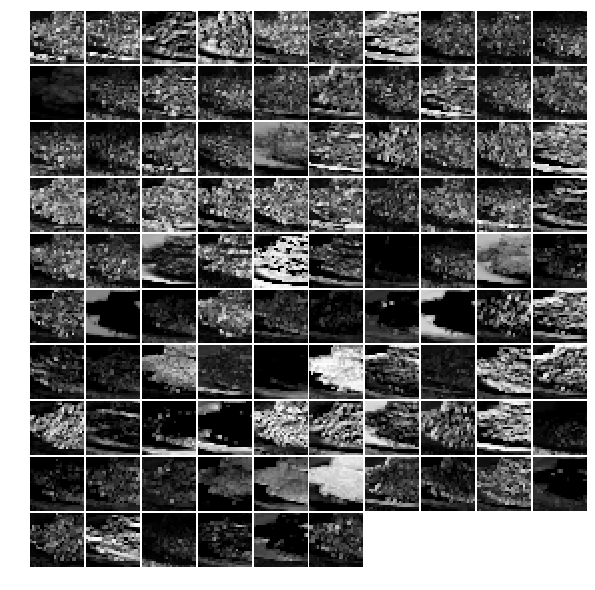

In [75]:
image1 = caffe.io.load_image(inputpath + "chicken_0107.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image1)
net.forward()
feature_test_norm1 = np.array(net.blobs['norm1'].data[0])
filters = net.blobs['norm1'].data[0]
vis_square(filters)

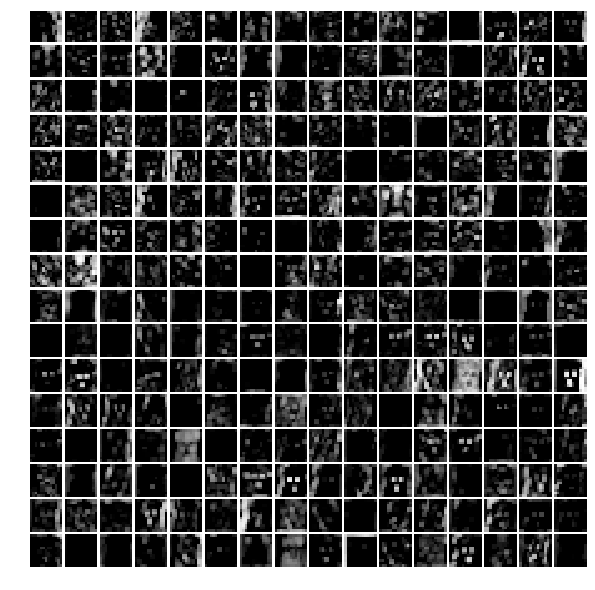

In [65]:
image2 = caffe.io.load_image(inputpath + "dog_0179.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image2)
net.forward()
feature_test_norm2 = np.array(net.blobs['norm2'].data[0])
filters2 = net.blobs['norm2'].data[0]
vis_square(filters2)

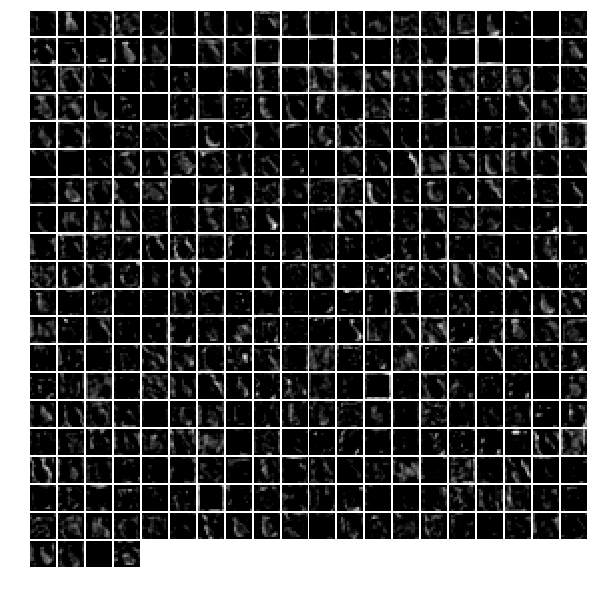

In [74]:
image3 = caffe.io.load_image(inputpath + "chicken_0114.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image3)
net.forward()
feature_test_conv3 = np.array(net.blobs['conv3'].data[0])
filters3 = net.blobs['conv3'].data[0]
vis_square(filters3)

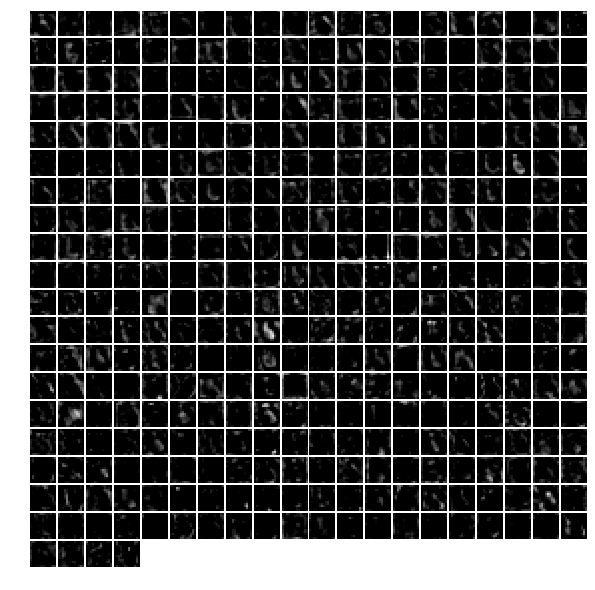

In [84]:
image4 = caffe.io.load_image(inputpath + "chicken_0114.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image4)
net.forward()
feature_test_conv4 = np.array(net.blobs['conv4'].data[0])
filters4 = net.blobs['conv4'].data[0]
vis_square(filters4)

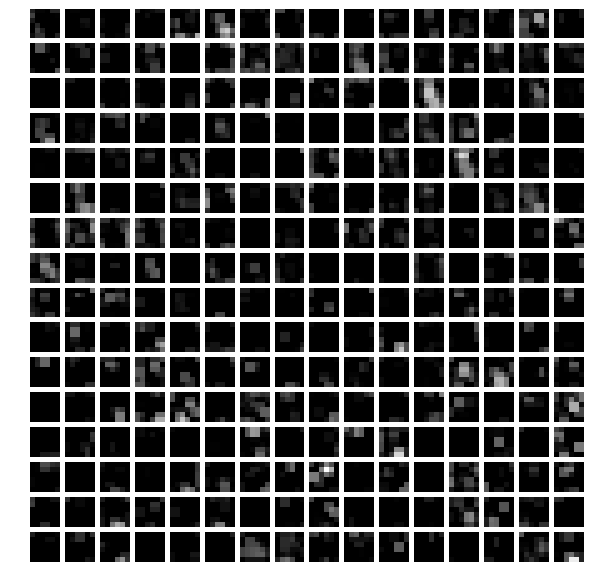

In [93]:
image5 = caffe.io.load_image(inputpath + "chicken_0114.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image5)
net.forward()
feature_test_pool5 = np.array(net.blobs['pool5'].data[0])
filters5 = net.blobs['pool5'].data[0]
vis_square(filters5)

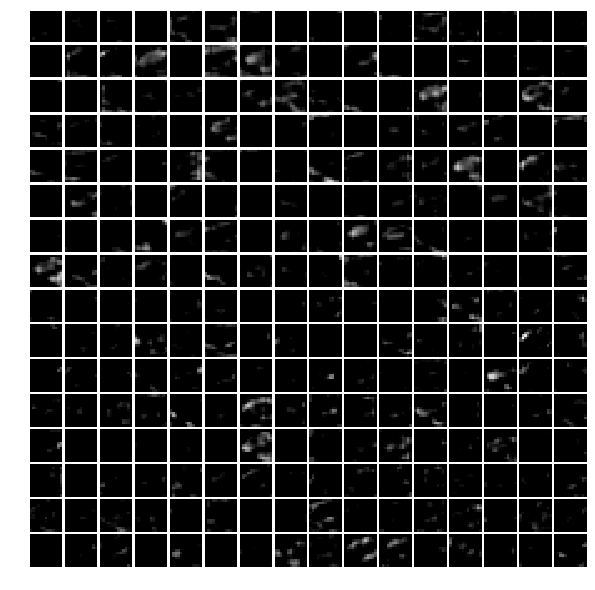

In [104]:
image6 = caffe.io.load_image(inputpath + "chicken_0037.jpg") 
# dog: 593, 945, 39, 56, 179; chicken: 37, 101,107, 114

net.blobs['data'].data[...] = transformer.preprocess('data', image6)
net.forward()
feature_test_conv5 = np.array(net.blobs['conv5'].data[0])
filters6 = net.blobs['conv5'].data[0]
vis_square(filters6)

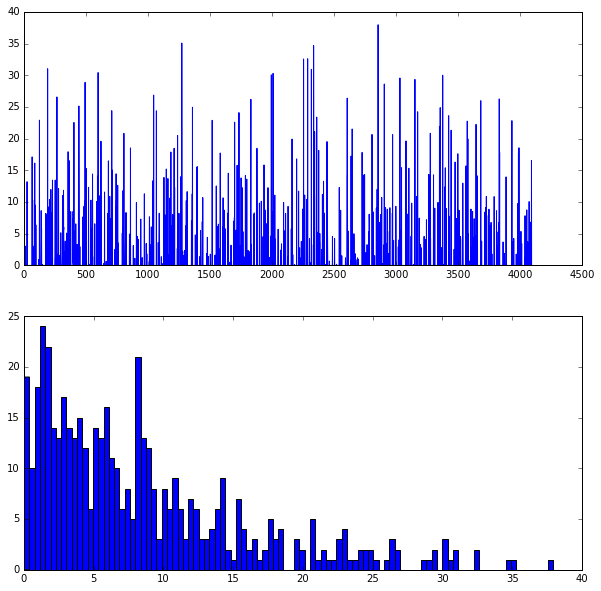

In [108]:
image7 = caffe.io.load_image(inputpath + "dog_0593.jpg") # 593, 945

net.blobs['data'].data[...] = transformer.preprocess('data', image7)
net.forward()
feature_test_fc6 = np.array(net.blobs['fc6'].data[0])
plt.subplot(2, 1, 1)
plt.plot(feature_test_fc6.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feature_test_fc6.flat[feature_test_fc6.flat > 0], bins=100)

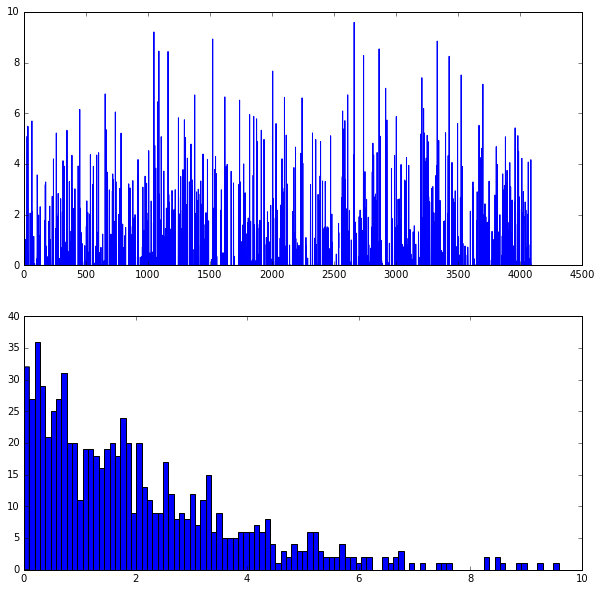

In [110]:
image8 = caffe.io.load_image(inputpath + "dog_0593.jpg") # 593, 945
net.blobs['data'].data[...] = transformer.preprocess('data', image8)
net.forward()
feature_test_fc7 = np.array(net.blobs['fc7'].data[0])
plt.subplot(2, 1, 1)
plt.plot(feature_test_fc7.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feature_test_fc7.flat[feature_test_fc7.flat > 0], bins=100)

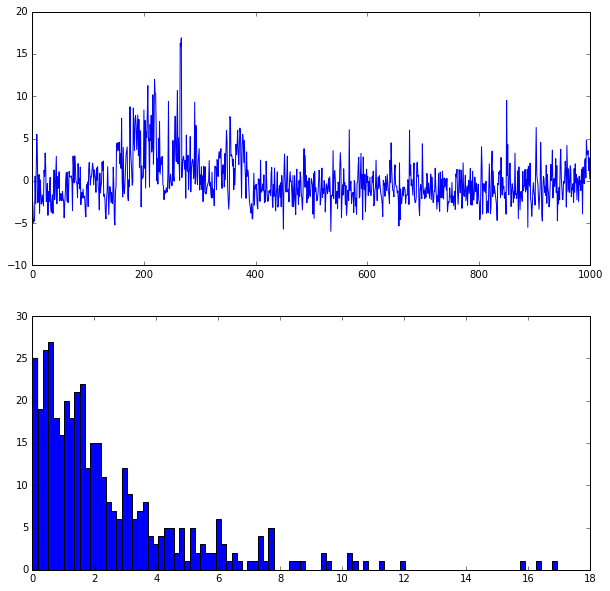

In [112]:
image9 = caffe.io.load_image(inputpath + "dog_0593.jpg") # 593, 945
net.blobs['data'].data[...] = transformer.preprocess('data', image9)
net.forward()
feature_test_fc8 = np.array(net.blobs['fc8'].data[0])
plt.subplot(2, 1, 1)
plt.plot(feature_test_fc8.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feature_test_fc8.flat[feature_test_fc8.flat > 0], bins=100)

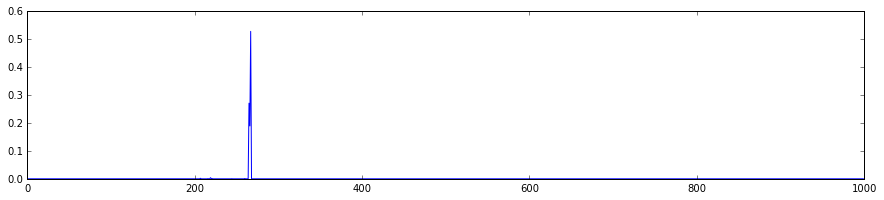

In [113]:
image10 = caffe.io.load_image(inputpath + "dog_0593.jpg") # 593, 945
net.blobs['data'].data[...] = transformer.preprocess('data', image10)
net.forward()
feature_test_prob = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feature_test_prob.flat)